This file has some fields changed for the rebuttal and others left the same, as a way to quickly generate figures for the rebuttal.

In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from GmGM import Dataset, GmGM
from strong_product_model import strong_product_model
from utilities import vec_kron_sum, sim_diag
import random
import BiGLasso_Methods as bg
from typing import Literal, Optional
from sklearn.metrics import auc
from collections import OrderedDict

SEED = 0

# Make palette colorblind friendly
plt.style.use('tableau-colorblind10')
hatches = ['|', '//', 'oo', 'x', '+', '-', 'OO', '.', '*', '\\']
lines = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5))]

# Prevent type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def fast_strong_product(
    Psi_1: np.ndarray,
    Psi_2w: np.ndarray,
    Psi_2b: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Theta = Psi_2b + np.eye(Psi_2b.shape[0])
    P, D = sim_diag(Theta, Psi_2w)
    Lam, V = np.linalg.eigh(Psi_1)
    core = 1 / vec_kron_sum([Lam, D])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2w.shape[0])
    z *= np.sqrt(core)
    Z = V @ z.reshape(Psi_1.shape[0], Psi_2w.shape[0]) @ np.linalg.inv(P)

    return Z

fast_strong_product(np.eye(5), np.eye(7), np.eye(7))
    

array([[ 0.3484894 , -0.72142381, -0.27996675,  0.17281386,  0.29866412,
        -1.38106289,  1.11005715],
       [-0.36699606, -0.03703592,  0.51797218, -0.36937467, -0.8852807 ,
         0.93714861,  0.99236502],
       [ 0.36171964,  0.57443432,  0.33505098, -0.08172956, -0.08892612,
         0.49452456,  0.62143998],
       [ 0.91962601, -0.1452945 , -0.27672285, -0.39206104,  0.8803896 ,
         0.76808086, -0.75831508],
       [ 0.02371281, -0.83386197, -0.18174905, -0.35086728,  0.30519057,
        -0.38909331, -0.53959474]])

In [4]:
def fast_kronecker_sum_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / vec_kron_sum([Lam1, Lam2])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_sum_model(np.eye(5), np.eye(7))
    

array([[ 0.42818198, -0.95383313, -1.16111275,  0.79396616, -0.62600785,
        -1.36616496, -0.77469557],
       [-0.03819068, -0.43285377,  0.08369671,  0.69510847,  1.17508077,
        -1.10791482,  0.01686581],
       [-0.06385539,  0.01915423, -0.27625449,  0.8842837 , -0.15776992,
         0.17054683, -0.35401927],
       [-0.32652145, -1.46206245,  0.07563708, -0.92083432,  0.29168721,
        -0.58496155,  0.27399894],
       [-0.52031558, -0.82778916, -0.22027198,  0.23680576,  0.67236512,
        -0.69169002, -0.67382403]])

In [5]:
def fast_kronecker_product_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / np.kron(Lam1, Lam2)

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_product_model(np.eye(5), np.eye(7))
    

array([[ 0.04238625,  1.58172753,  1.00997825,  1.16672475,  0.30561573,
        -0.39983279,  0.67712782],
       [-0.72914973,  1.11200003,  0.62996071,  1.1489409 ,  0.38340703,
         1.14929322, -1.26806046],
       [-0.19741499, -0.09156053, -0.92098003, -0.64781844, -0.24533925,
         2.22217729,  0.51456689],
       [-1.9514859 , -0.38408682,  2.08475064,  0.80569249, -0.5317166 ,
         1.76805035, -0.84646224],
       [-0.1634025 ,  0.35108416, -1.41971137, -0.31066255,  0.73135573,
         0.26713678, -0.60008883]])

In [6]:
def fast_kronecker_sum_squared_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / vec_kron_sum([Lam1, Lam2])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= core
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_sum_squared_model(np.eye(5), np.eye(7))
    

array([[-0.31161815, -0.07470072,  0.26206059, -0.06038284, -0.15242837,
        -0.05033399, -0.13329401],
       [ 0.3369445 ,  0.20108286, -0.08438933,  0.0360638 ,  0.13317129,
        -0.4327354 , -0.35562705],
       [ 0.29280884,  0.2170516 , -1.57862468, -0.47796009, -0.31127675,
        -0.17479751,  0.52980201],
       [ 0.47866592, -0.35994571, -1.09345163, -0.2498644 ,  0.07557064,
         0.04717464,  0.2653184 ],
       [ 0.35759943, -0.63827636, -0.23957387, -0.11209073,  0.49007224,
        -0.61650736,  0.02021056]])

In [7]:
def pr_curve(
    ground_truth: np.ndarray,
    output: np.ndarray,
    num_points: int = 1000
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    # precisions = np.zeros(num_points)
    # recalls = np.zeros(num_points)
    #thresholds = np.linspace(-0.1, np.max(output), num_points)

    # Order output by decreasing value
    output_flat = output.flatten()
    order = np.argsort(output_flat)[::-1]

    # Sample evenly num_points thresholds from order
    thresholds = output_flat[order][::max(1, len(output) // num_points)]
    precisions = np.zeros(len(thresholds))
    recalls = np.zeros(len(thresholds))

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    if (output == np.eye(output.shape[0])).all():
        return None, None

    # Iterate over thresholds
    for i, threshold in enumerate(thresholds):
        # Threshold output
        output_thresholded = (output > threshold).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

def pr_curve_alg(
    ground_truth: np.ndarray,
    alg: callable,
    reg_params: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(reg_params.shape[0])
    recalls = np.zeros(reg_params.shape[0])
    #thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over reg_params
    for i, param in enumerate(reg_params):
        # Threshold output
        print(f"TeraLasso lambda: {param}")
        output = alg(param)
        output_thresholded = (output != 0).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

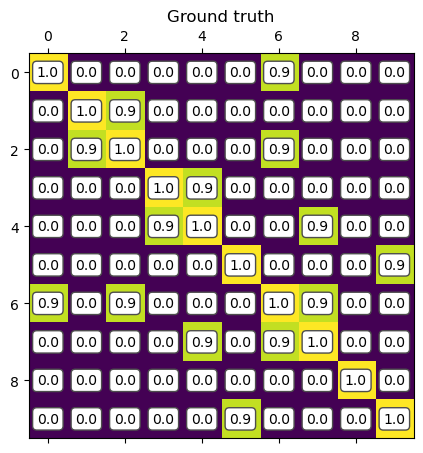

In [7]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")

for (i, j), z in np.ndenumerate(ground_truth):
    ax1.text(
        j,
        i,
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )

In [119]:
# Create a random graph
def random_graph(graph):
    ground_truth = np.array(graph.get_adjacency().data)
    gt_sums = 1 / np.sqrt(ground_truth.sum(axis=0))
    ground_truth = gt_sums.reshape(1, -1) * ground_truth * gt_sums.reshape(-1, 1)

    # Add diagonal so that it forms a PSD matrix!
    ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
    return ground_truth

def precision_test(
    num_nodes: int,
    graphs: list[ig.Graph],
    title: str,
    num_trials: int = 10,
    model: Literal[
        "Strong Product",
        "Kronecker Sum",
        "Kronecker Product",
        "Kronecker Sum Squared",
    ] = "Strong Product",
    cb_cw_ratio: float = 1.0,
    data_mod: Optional[Literal["exp", "cubed", "t", "logt", "expgauss"]] = None
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(SEED)
    np.random.seed(SEED)

    if model == "Kronecker Sum Squared":
        graphs = [graphs[0], graphs[1], graphs[1]]
    
    ground_truth_r = random_graph(graphs[0])
    ground_truth_cw = random_graph(graphs[1]) / np.sqrt(cb_cw_ratio)
    ground_truth_cb = np.sqrt(cb_cw_ratio) * random_graph(graphs[2])

    if model == "Kronecker Sum Squared":
        pass
        #ground_truth_cw = ground_truth_cw @ ground_truth_cw

    if model == "Strong Product":
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 7))
    elif model == "Kronecker Product":
        fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(10, 7))
        ax2 = None
    elif model == "Kronecker Sum":
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 7))
        ax3 = None
    elif model == "Kronecker Sum Squared":
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 7))


    algorithms = (
        [
            "Strong Product",
            "GmGM",
            "Strong Product [Kronecker Sum]",
            "Strong Product [Kronecker Product]",
            #"TeraLasso",
        ]
    )
    for idx, algorithm in enumerate(algorithms):
        print(f"Running {algorithm}")
        ps_r = []
        rs_r = []
        ps_cw = []
        rs_cw = []
        ps_cb = []
        rs_cb = []

        for i in range(num_trials):
            print(f"\tTrial {i+1} of {num_trials}")

            # Generate data
            #dfs = num_nodes
            #data_dependencies = stats.wishart(df=dfs, scale=np.eye(num_nodes)).rvs()
            #data_dependencies /= dfs
            if model == "Strong Product":
                output = fast_strong_product(
                    ground_truth_r,
                    ground_truth_cw,
                    ground_truth_cb
                )
            elif model == "Kronecker Sum":
                output = fast_kronecker_sum_model(
                    ground_truth_r,
                    ground_truth_cw
                )
            elif model == "Kronecker Product":
                output = fast_kronecker_product_model(
                    ground_truth_r,
                    ground_truth_cb
                )
            elif model == "Kronecker Sum Squared":
                output = fast_kronecker_sum_squared_model(
                    ground_truth_r,
                    ground_truth_cb
                )
            else:
                raise Exception(f"Unknown model: {model}")

            if data_mod == "exp":
                output = np.exp(output)
            elif data_mod == "squared":
                output = output**3
            elif data_mod == "+1":
                output += output.max() - output.min()
            elif data_mod == "t":
                dfs = 5
                chis = stats.chi2(df=dfs).rvs(size=output.shape)
                output = output / np.sqrt(chis / dfs)
            elif data_mod == "logt":
                dfs = 10
                chis = stats.chi2(df=dfs).rvs(size=output.shape)
                output = np.exp(output / np.sqrt(chis / dfs))
            elif data_mod == "expgauss":
                output += np.random.exponential(1/1.5, size=output.shape)
            elif data_mod == "sqrt":
                output = (output - output.min() + 1)**(1/5)
                output -= output.mean()

            dataset = Dataset(
                dataset={"data": output[np.newaxis, :, :]},
                structure={"data": ("", "rows", "columns")}
            )
            result = None
            run_alg = None
            if algorithm == "GmGM":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = np.eye(num_nodes)
                        self.precision_matrices["cols_within_rows"] = precmats["columns"]
                result = GmGM(
                    dataset,
                    to_keep=0.5,
                    threshold_method="statistical-significance",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                result = result_container(result.precision_matrices)
            elif algorithm == "Strong Product":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3
                )
                result = result_container(result)
            elif algorithm == "Strong Product [Kronecker Sum]":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3,
                    fix_Theta=True
                )
                result = result_container(result)
            elif algorithm == "Strong Product [Kronecker Product]":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3,
                    fix_Psi_2w=True
                )
                result = result_container(result)
            elif algorithm == "TeraLasso":
                def alg(reg_param):
                    return bg.TeraLasso(
                        dataset,
                        reg_param,
                        use_nonparanormal_skeptic=False
                    ).precision_matrices["rows"].toarray()
                run_alg = alg
            else:
                raise Exception(f"Unknown algorithm: {algorithm}")

            if run_alg is None:
                if hasattr(result.precision_matrices["rows"], 'toarray'):
                    result.precision_matrices["rows"] = result.precision_matrices["rows"].toarray()
                if hasattr(result.precision_matrices["cols_within_rows"], 'toarray'):
                    result.precision_matrices["cols_within_rows"] = \
                        result.precision_matrices["cols_within_rows"].toarray()
                if hasattr(result.precision_matrices["cols_between_rows"], 'toarray'):
                    result.precision_matrices["cols_between_rows"] = \
                        result.precision_matrices["cols_between_rows"].toarray()
                    
                ys_r, xs_r = pr_curve(ground_truth_r, result.precision_matrices["rows"])
                ys_cw, xs_cw = pr_curve(ground_truth_cw, result.precision_matrices["cols_within_rows"])
                ys_cb, xs_cb = pr_curve(ground_truth_cb, result.precision_matrices["cols_between_rows"])
            else:
                # Manually chosen bounds to cover span from ~perfect recall to ~perfect precision
                if algorithm == "TeraLasso":
                    reg_params = 10**np.linspace(-2, 0, 25)
                ys_r, xs_r = pr_curve_alg(ground_truth_r, run_alg, reg_params)
                ys_cw, xs_cw = pr_curve_alg(ground_truth_cw, run_alg, reg_params)
                ys_cb, xs_cb = pr_curve_alg(ground_truth_cb, run_alg, reg_params)
                #print(ys, xs)
            
            if ys_r is not None and xs_r is not None:
                ps_r.append(ys_r)
                rs_r.append(xs_r)
            if ys_cw is not None and xs_cw is not None:
                ps_cw.append(ys_cw)
                rs_cw.append(xs_cw)
            if ys_cb is not None and xs_cb is not None:
                ps_cb.append(ys_cb)
                rs_cb.append(xs_cb)


        num_points = 100
        xs = np.linspace(0, 1, num_points)

        if algorithm == "GmGM":
            label = "GmGM"
        elif algorithm == "TeraLasso":
            label = "TeraLasso"
        elif algorithm == "Strong Product":
            label = "Strong Product"
        elif algorithm == "Strong Product [Kronecker Sum]":
            label = "Kronecker Sum"
        elif algorithm == "Strong Product [Kronecker Product]":
            label = "Kronecker Product"
        else:
            raise Exception(f"Unknown algorithm: {algorithm}")

        if algorithm == "TeraLasso":
            # Tableau color is too light
            lineplot = ax1.plot(-1, -1, color='#888888')
        elif algorithm == "TeraLasso + mean estimation":
            lineplot = ax1.plot(-1, -1, color='#990000')
        else:
            lineplot = ax1.plot(-1, -1)
        xs = np.linspace(0.01, 1, 100)

        for ps, rs, ax, name in zip(
            [ps_r, ps_cw, ps_cb],
            [rs_r, rs_cw, rs_cb],
            [ax1, ax2, ax3],
            ["rows", "columns (within-row)", "columns (between-row)"]
        ):
            if ax is None:
                continue
            min_ys = np.zeros(100) + 1
            max_ys = np.zeros(100)
            if len(ps) == 0:
                continue
            for p, r in zip(ps, rs):
                f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
                min_ys = np.minimum(min_ys, f(xs))
                max_ys = np.maximum(max_ys, f(xs))
                #plt.plot(xs, f(xs), color='black', alpha=0.1)
            ax.plot(
                xs,
                min_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            ax.plot(
                xs,
                max_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            # ax.plot(
            #     xs,
            #     (min_ys + max_ys) / 2,
            #     color=lineplot[0].get_color(),
            #     label=label,
            #     linestyle=lines[idx]
            # )
            ax.plot(
                sum(rs) / len(rs),
                sum(ps) / len(ps),
                color=lineplot[0].get_color(),
                label=label,
                linestyle=lines[idx]
            )
            ax.fill_between(
                xs,
                min_ys,
                max_ys,
                color=lineplot[0].get_color(),
                alpha=0.1
            )#, hatch=hatches[idx]+hatches[idx])

            print(f"{algorithm}@{name} AUC: {auc(sum(rs) / len(rs), sum(ps) / len(ps))}")

    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Recall\n\n')
        ax.set_ylabel('Precision')
        #ax.legend()

    if ax1 is not None:
        ax1.set_title("Rows")
    if ax2 is not None:
        ax2.set_title("Columns\n(within-row)")
    if ax3 is not None:
        ax3.set_title("Columns\n(between-row)")

    # Increase font size
    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(24)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

    # Increase legend font size
    handles = []
    labels = []
    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        #ax.legend(prop={'size': 12})
        _handles, _labels = ax.get_legend_handles_labels()
        handles.extend(_handles)
        labels.extend(_labels)

    # Put in ordered dict to remove duplicate labels
    _dict = OrderedDict(zip(labels, handles))
    fig.legend(_dict.values(), _dict.keys(), loc='lower center', ncol=5, fontsize=24)

    if model == "Strong Product" or model == "Kronecker Sum Squared":
        axs = (ax1, ax2, ax3)
    elif model == "Kronecker Product":
        axs = (ax1, ax3)
    elif model == "Kronecker Sum":
        axs = (ax1, ax2)

    fig.suptitle(
            f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)'
            + f'\n [{title}]',
            size=24
        )

    fig.tight_layout()
    
    return fig, axs

# Run Tests

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product@rows AUC: 0.19403505017371794
Strong Product@columns (within-row) AUC: 0.16488461730219076
Strong Product@columns (between-row) AUC: 0.14732022849354848
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
GmGM@rows AUC: 0.09034906423003716
GmGM@columns (within-row) AUC: 0.08948394171550939
Running Strong Product [Kronecker Sum]
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:114: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product [Kronecker Sum]@rows AUC: 0.19013771263633072
Strong Product [Kronecker Sum]@columns (within-row) AUC: 0.18802595947366585
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product [Kronecker Product]@rows AUC: 0.16151724057422995
Strong Product [Kronecker Product]@columns (between-row) AUC: 0.12131149530662663


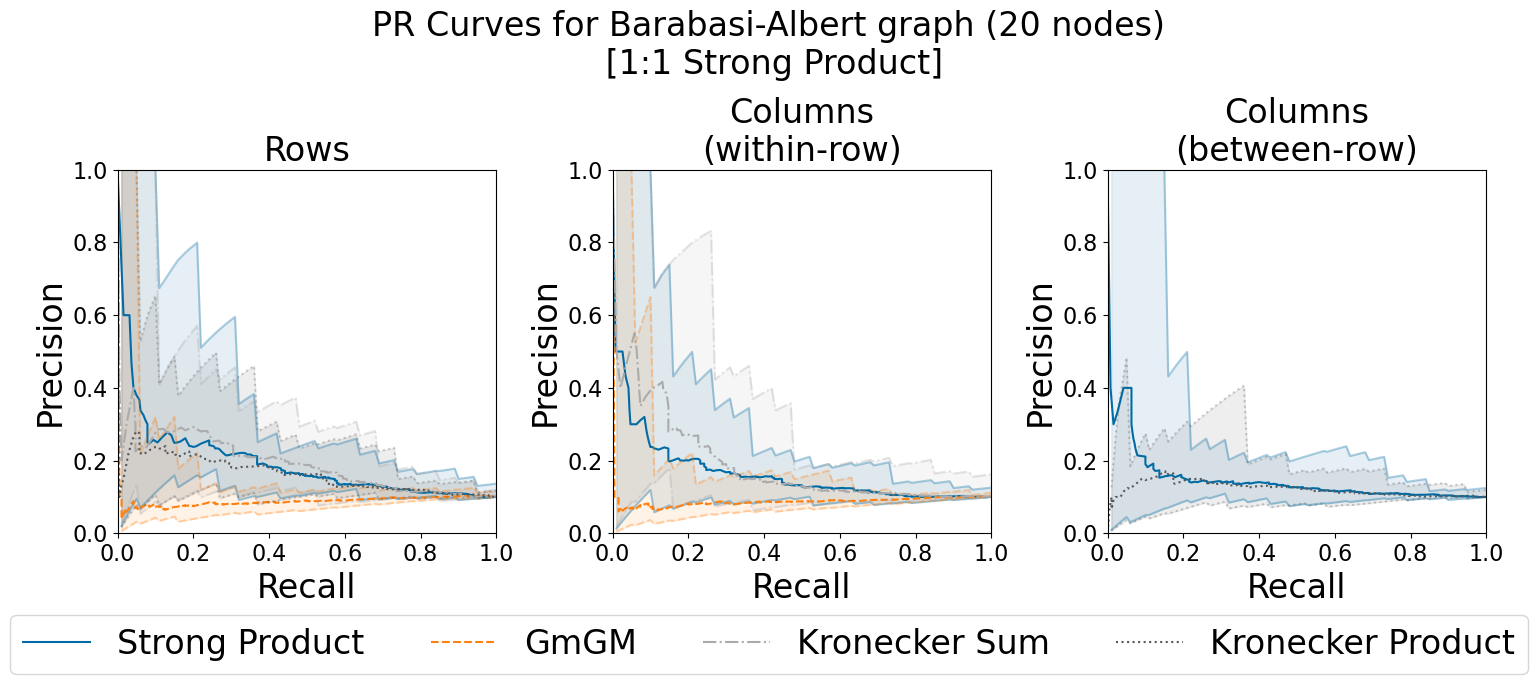

In [101]:
# This is a quick tester line to ensure the figure gets generated properly.
# Ignore it.

# Create a random graph
num_nodes = 20
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="1:1 Strong Product",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1,
    data_mod="expgauss"
)
fig.savefig("out_figs/synthetic/TEST.pdf", bbox_inches='tight')

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product@rows AUC: 0.6588140349307792
Strong Product@columns (within-row) AUC: 0.0693179599437729
Strong Product@columns (between-row) AUC: 0.07360257866823225
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:114: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


GmGM@rows AUC: 0.012428150235953919
GmGM@columns (within-row) AUC: 0.012743072165664822
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product [Kronecker Sum]@rows AUC: 0.5125253440288049
Strong Product [Kronecker Sum]@columns (within-row) AUC: 0.050071789409530165
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product [Kronecker Product]@rows AUC: 0.3365104694289884
Strong Product [Kronecker Product]@columns (between-row) AUC: 0.05027492863650304


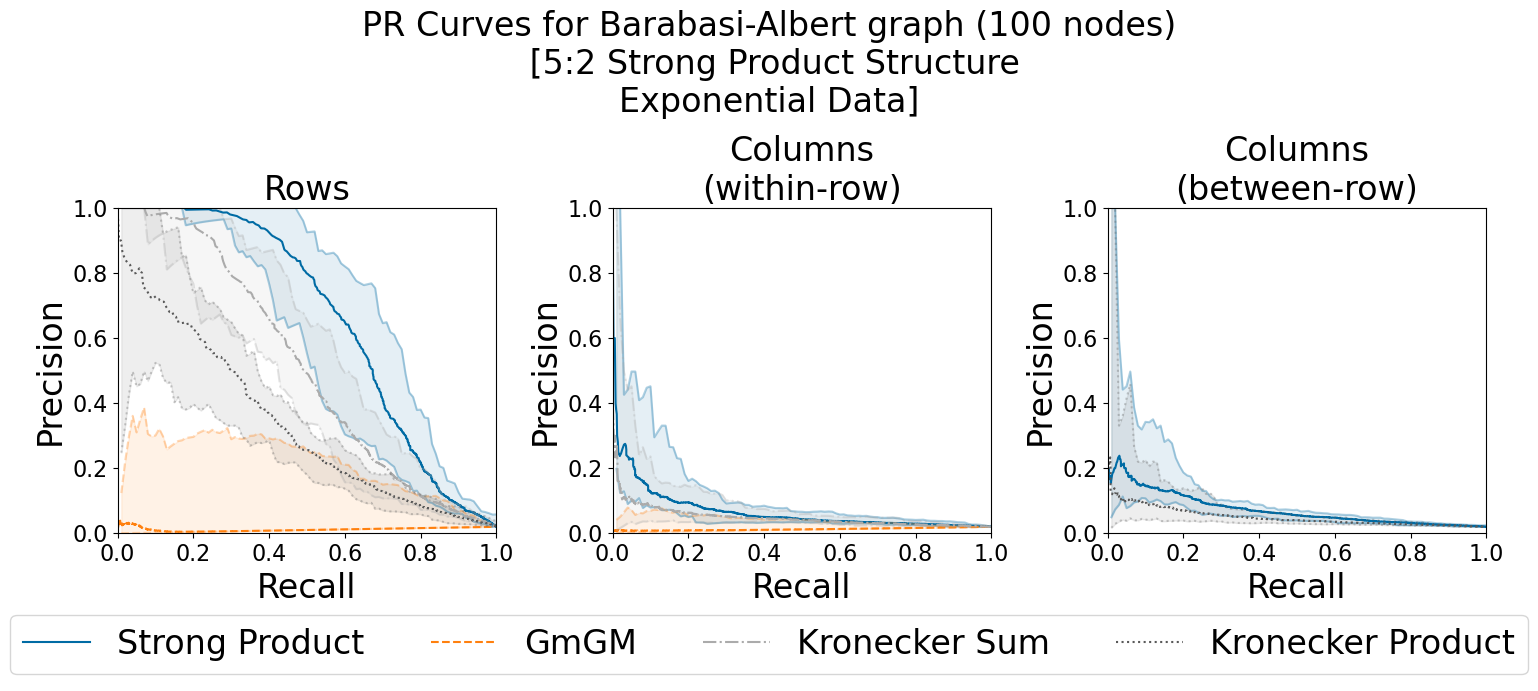

In [63]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="5:2 Strong Product Structure\nExponential Data",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5,
    data_mod="exp"
)
#fig.savefig('./out_figs/synthetic/sp1_barabasi_500_nodes_1to1_sylvester.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product@rows AUC: 0.43807864792531115
Strong Product@columns (within-row) AUC: 0.047280550554594125
Strong Product@columns (between-row) AUC: 0.05762854530526626
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:114: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


GmGM@rows AUC: 0.010349402728751848
GmGM@columns (within-row) AUC: 0.012399437153228178
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product [Kronecker Sum]@rows AUC: 0.32282285820462603
Strong Product [Kronecker Sum]@columns (within-row) AUC: 0.040352356423877904
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product [Kronecker Product]@rows AUC: 0.37824235086575275
Strong Product [Kronecker Product]@columns (between-row) AUC: 0.046510145808636195


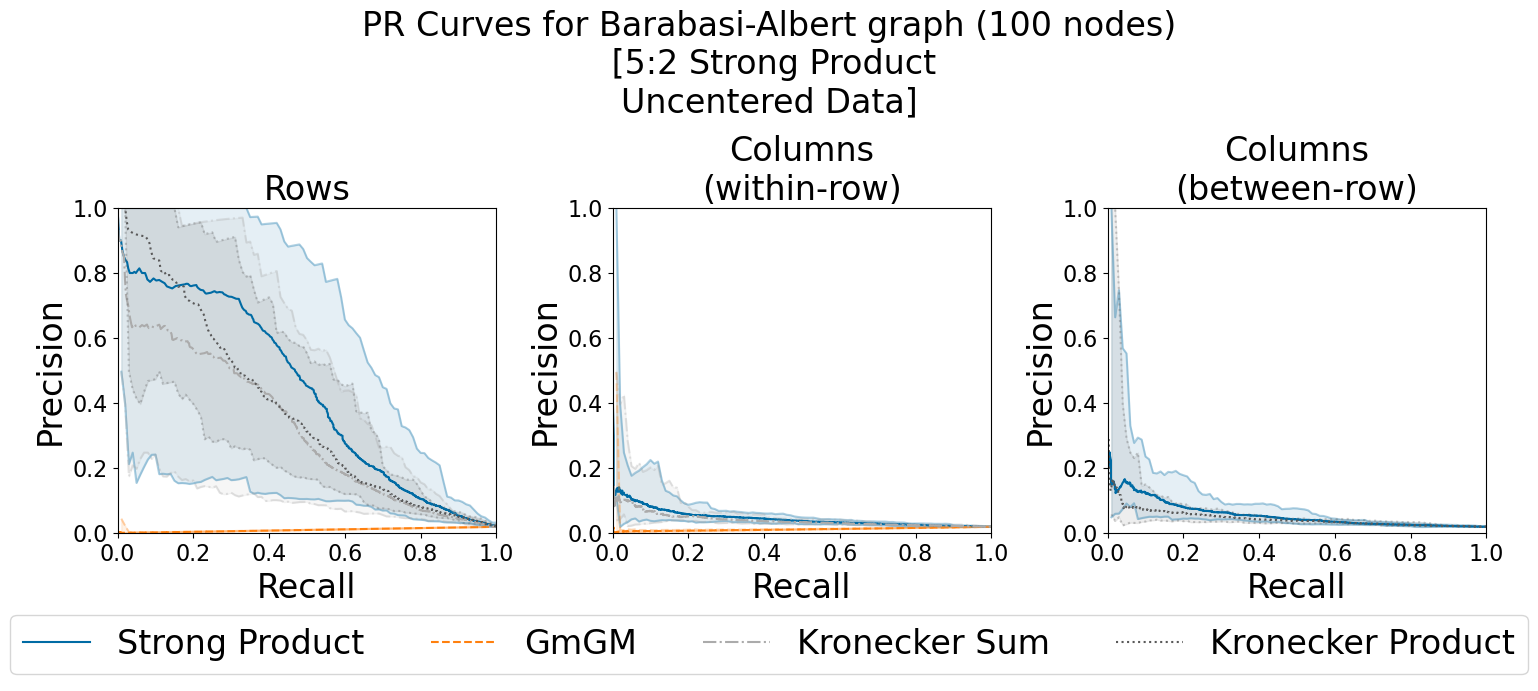

In [95]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="5:2 Strong Product\nUncentered Data",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5,
    data_mod="logt"
)
#fig.savefig('./out_figs/synthetic/sp1_barabasi_500_nodes_1to1_sylvester.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product@rows AUC: 0.8323025670354252
Strong Product@columns (within-row) AUC: 0.15830942860758063
Strong Product@columns (between-row) AUC: 0.11508123486220875
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:114: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
GmGM@rows AUC: 0.7534078753863748
GmGM@columns (within-row) AUC: 0.0838835799270618
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Strong Product [Kronecker Product]@rows AUC: 0.8191537115393949
Strong Product [Kronecker Product]@columns (between-row) AUC: 0.13231074129388318


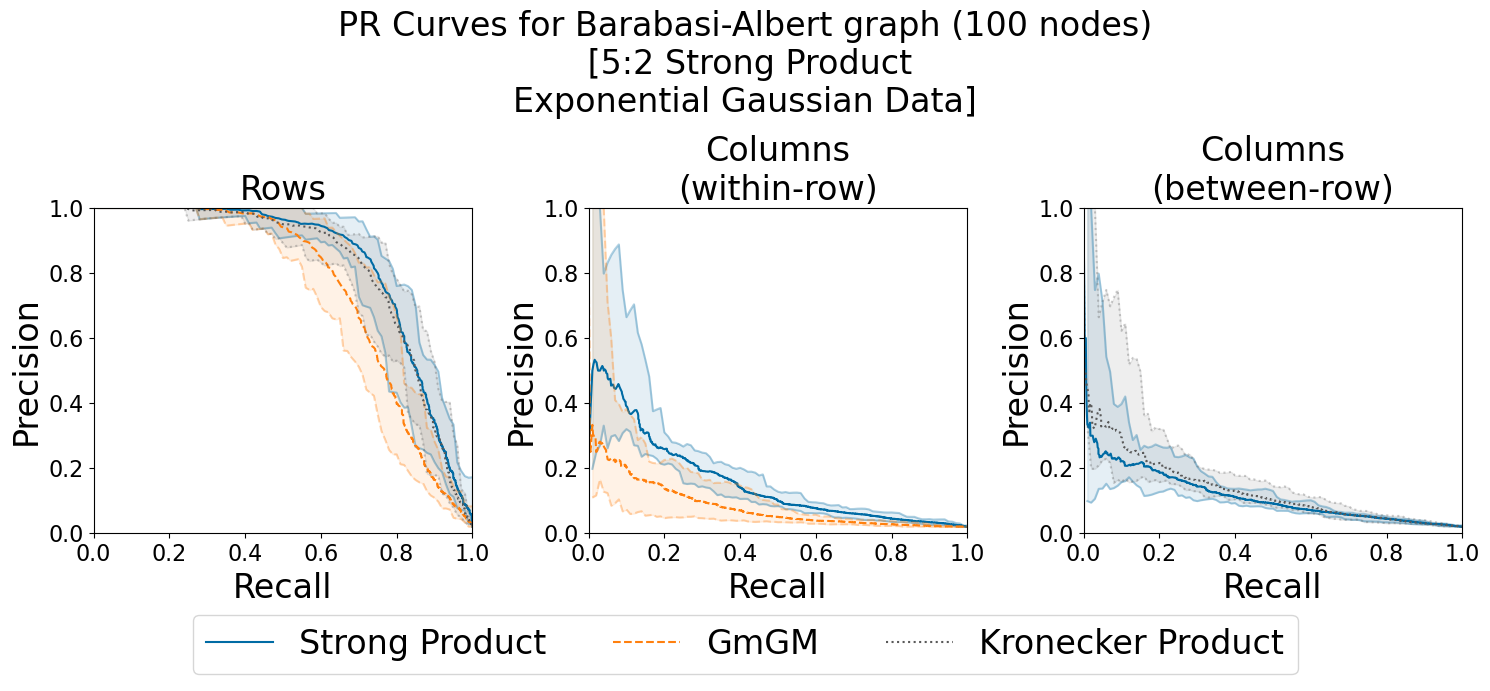

In [120]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="5:2 Strong Product\nExponential Gaussian Data",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5,
    data_mod="sqrt"
)
#fig.savefig('./out_figs/synthetic/sp1_barabasi_500_nodes_1to1_sylvester.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:114: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:231: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


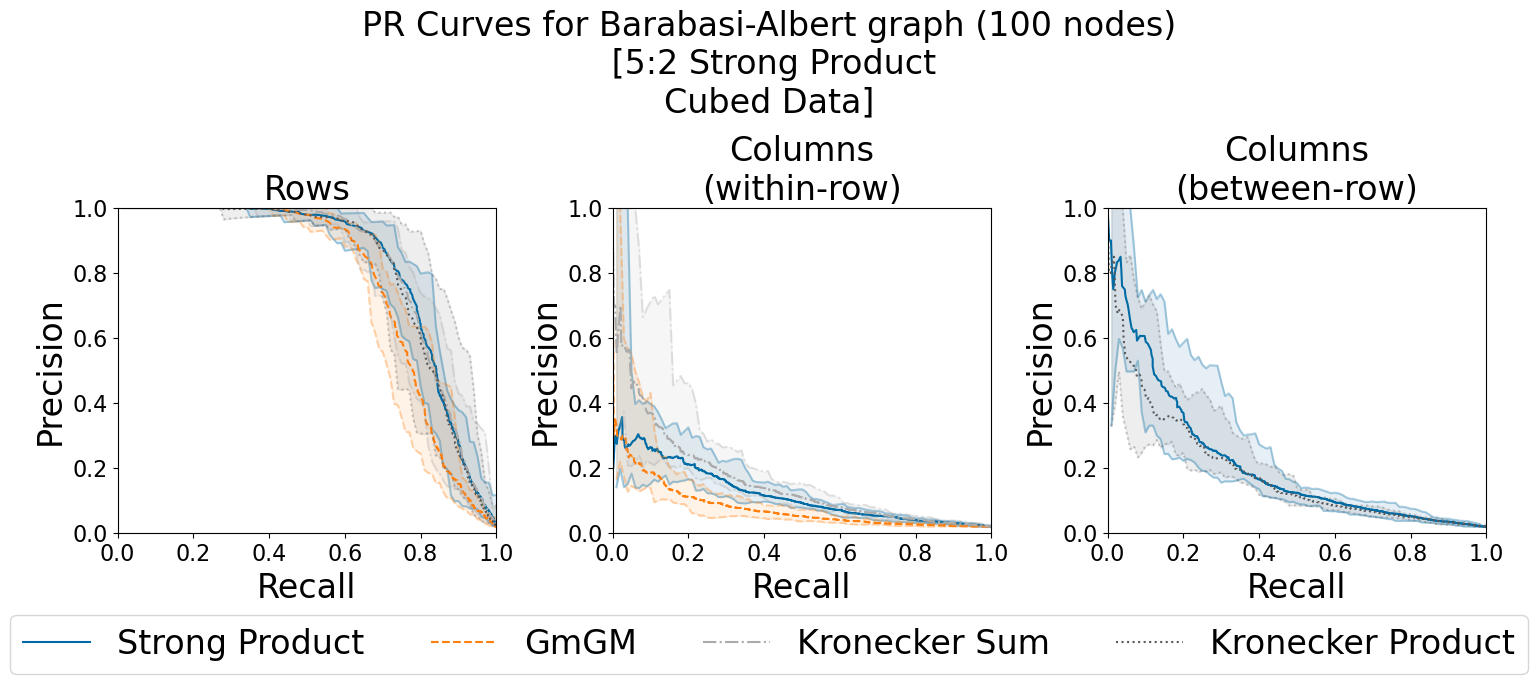

In [56]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="5:2 Strong Product\nCubed Data",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5,
    data_mod="cubed"
)
#fig.savefig('./out_figs/synthetic/sp1_barabasi_500_nodes_1to1_sylvester.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
logm result may be inaccurate, approximate err = 0.026368477494434463
logm result may be inaccurate, approximate err = 0.027290216042649404
logm result may be inaccurate, approximate err = 4.980711939009871e-05
logm result may be inaccurate, approximate err = 1.118046125939411e-06
logm result may be inaccurate, approximate err = 4.4626721142193327e-05
	Trial 5 of 10
	Trial 6 of 10
logm result may be inaccurate, approximate err = 0.027493718625960218
	Trial 7 of 10
	Trial 8 of 10
logm result may be inaccurate, approximate err = 0.026466997704229774
logm result may be inaccurate, approximate err = 0.024995415067828125
	Trial 9 of 10
logm result may be inaccurate, approximate err = 0.026647582229326956
logm result may be inaccurate, approximate err = 0.027452125627074005
	Trial 10 of 10
logm result may be inaccurate, approximate err = 0.026632075371394583
logm result may be inaccurate, approximate err = 0.0

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


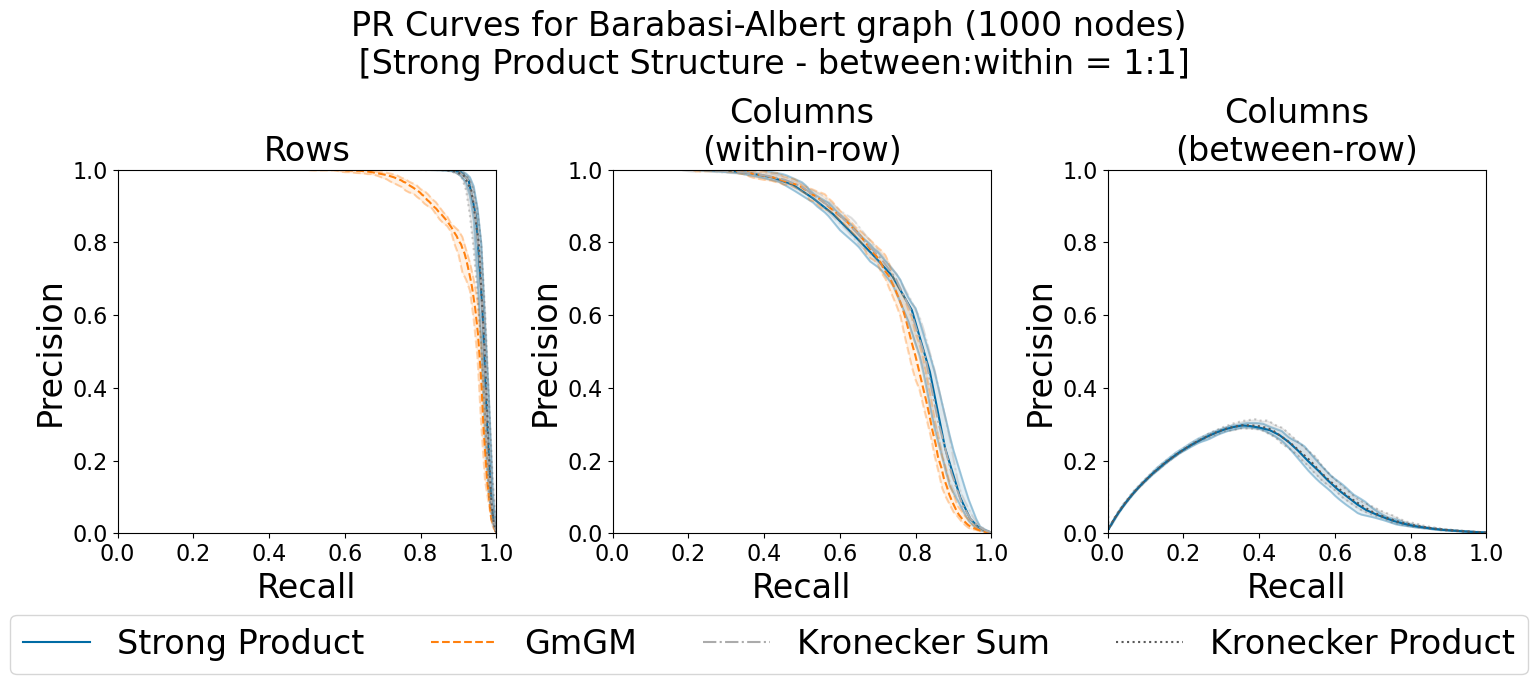

In [28]:
# Create a random graph
# This cell takes a very long time to run!!!
num_nodes = 1000
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 1:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1
)
fig.savefig('./out_figs/synthetic/sp1_barabasi_1000_nodes_1to1.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.024144288625115723
logm result may be inaccurate, approximate err = 4.4717492346405574e-05
logm result may be inaccurate, approximate err = 1.2576418917901984e-06
logm result may be inaccurate, approximate err = 4.52412564523515e-05
logm result may be inaccurate, approximate err = 2.1064821618580815e-05
logm result may be inaccurate, approximate err = 4.5366150433807825e-05
logm result may be inaccurate, approximate err = 1.268423408871494e-06
logm result may be inaccurate, approximate err = 4.538932498355678e-05
logm result may be inaccurate, approximate err = 4.5389646252165926e-05
logm result may be inaccurate, approximate err = 4.538972656485941e-05
logm result may be inaccurate, approximate err = 4.538976671796285e-05
logm result may be inaccurate, approximate err = 1.2685251706567852e-06
logm result may be inaccurate, approximate err = 4.53897918198116e-05
	Trial 2 of 10
logm result may be in

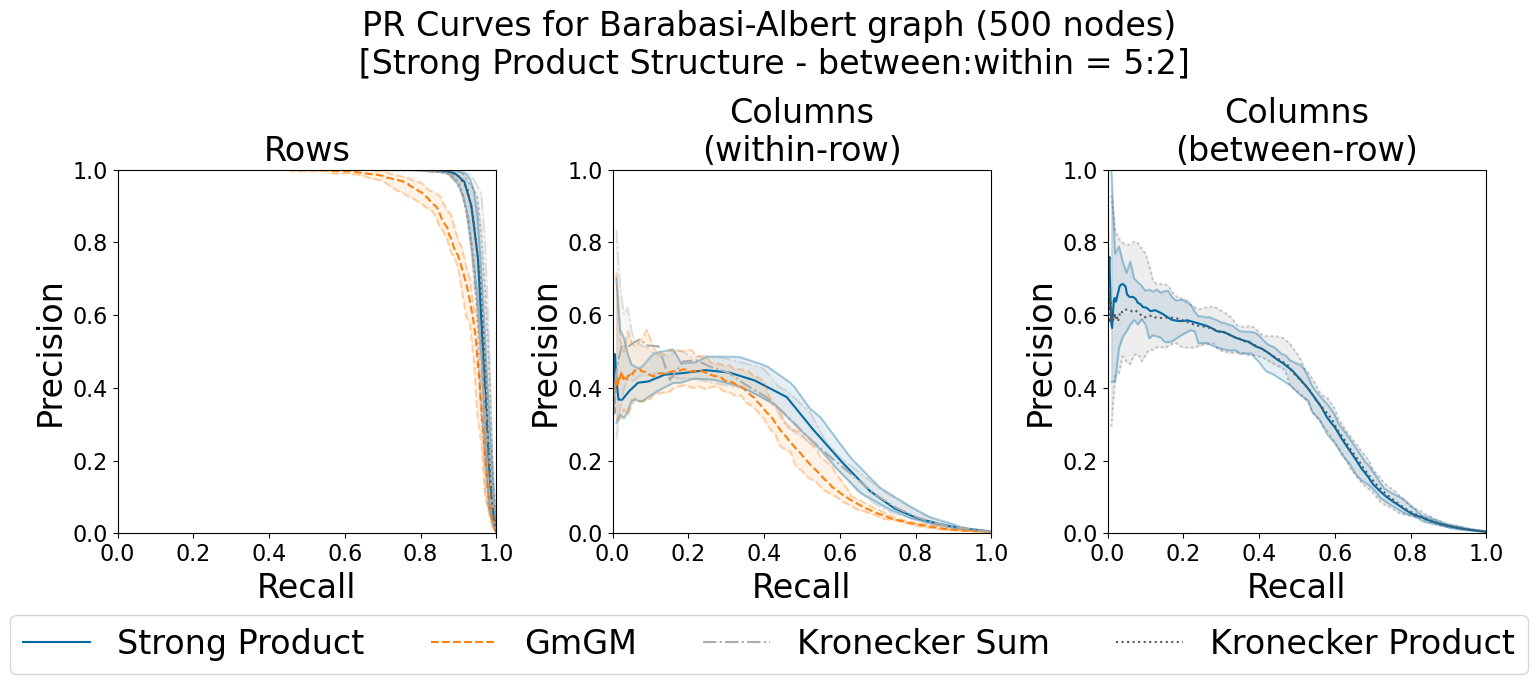

In [11]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 5:2",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5
)
fig.savefig('./out_figs/synthetic/sp1_barabasi_500_nodes.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


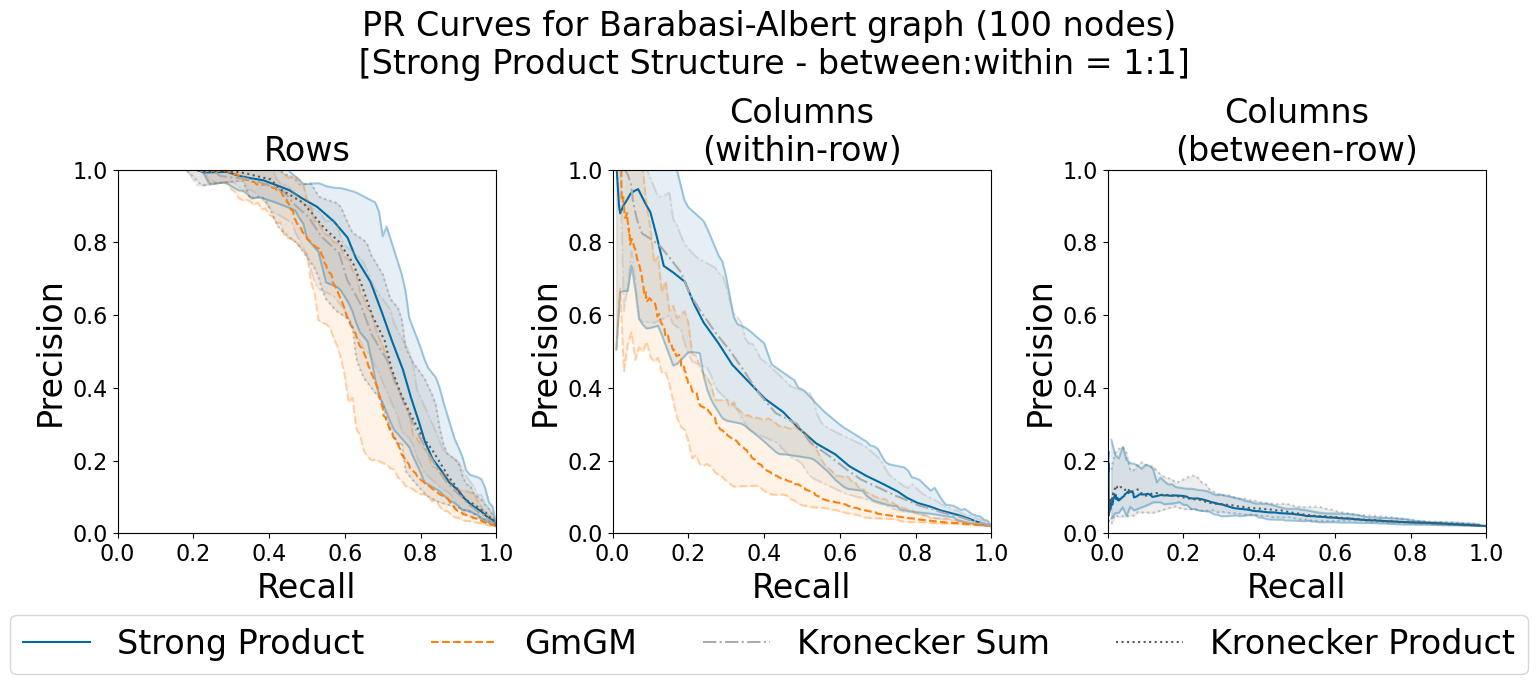

In [12]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 1:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1.0
)
fig.savefig('./out_figs/synthetic/sp1_barabasi.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


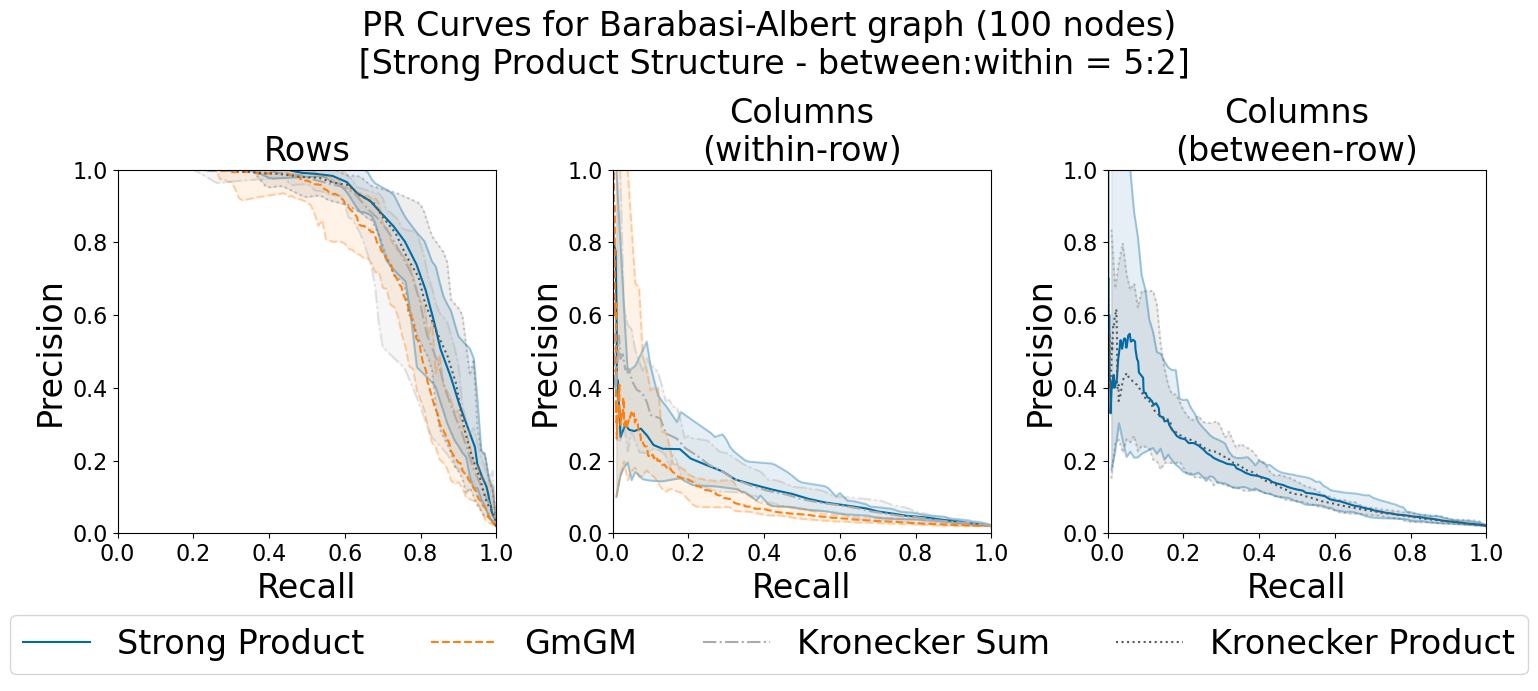

In [13]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 5:2",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5
)
fig.savefig('./out_figs/synthetic/sp5_2_barabasi.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 4.349558770567393e-05
logm result may be inaccurate, approximate err = 4.361271078241215e-05
logm result may be inaccurate, approximate err = 3.258431590585688e-05
logm result may be inaccurate, approximate err = 4.3672730622743436e-05
logm result may be inaccurate, approximate err = 2.8522762396408724e-06
logm result may be inaccurate, approximate err = 1.2840036156519675e-05
	Trial 2 of 10
logm result may be inaccurate, approximate err = 4.392419315603772e-05
logm result may be inaccurate, approximate err = 4.309919921476937e-06
logm result may be inaccurate, approximate err = 2.265822907509788e-06
logm result may be inaccurate, approximate err = 4.406863458907928e-05
logm result may be inaccurate, approximate err = 4.389185410756368e-05
logm result may be inaccurate, approximate err = 4.407430261570153e-05
logm result may be inaccurate, approximate err = 2.266470769256385e-06
logm result may be in

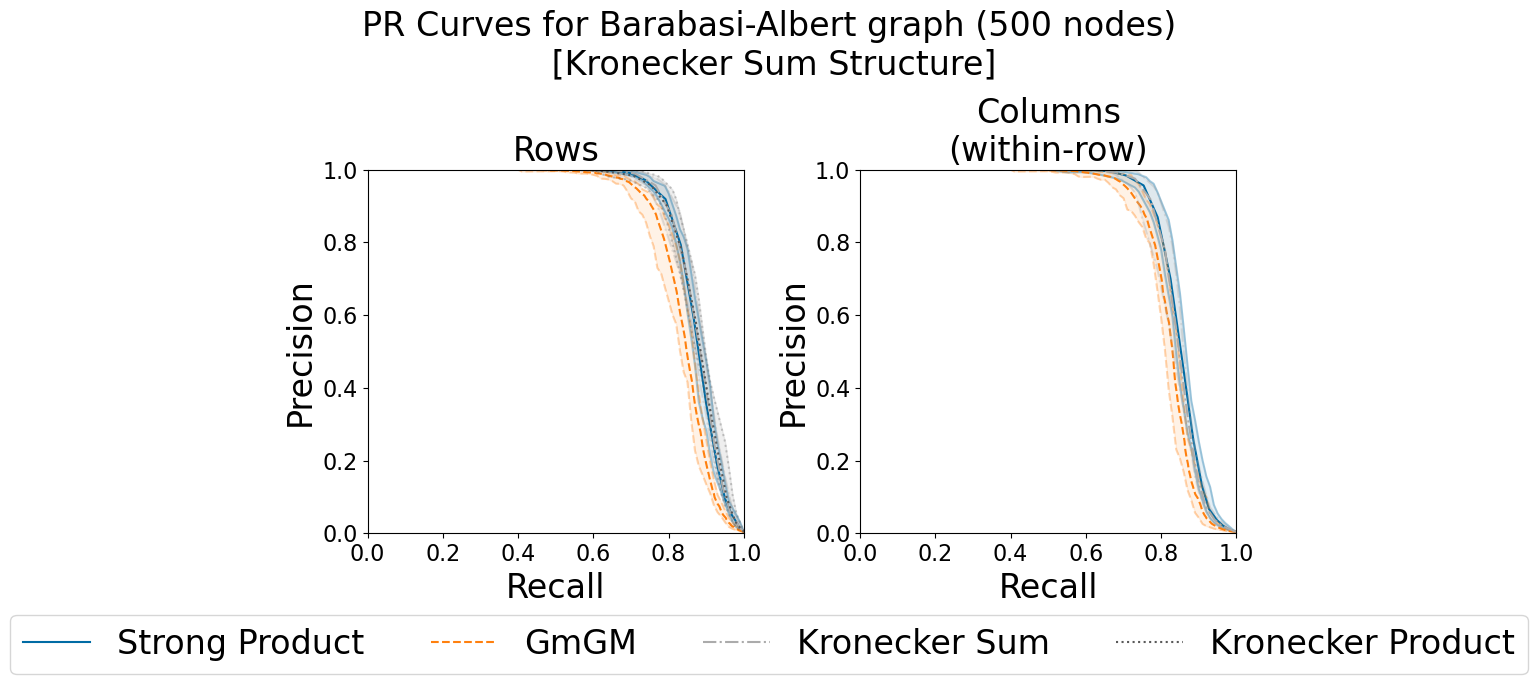

In [14]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Sum Structure",
    num_trials=10,
    model="Kronecker Sum"
)
fig.savefig('./out_figs/synthetic/ks_barabasi_500.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


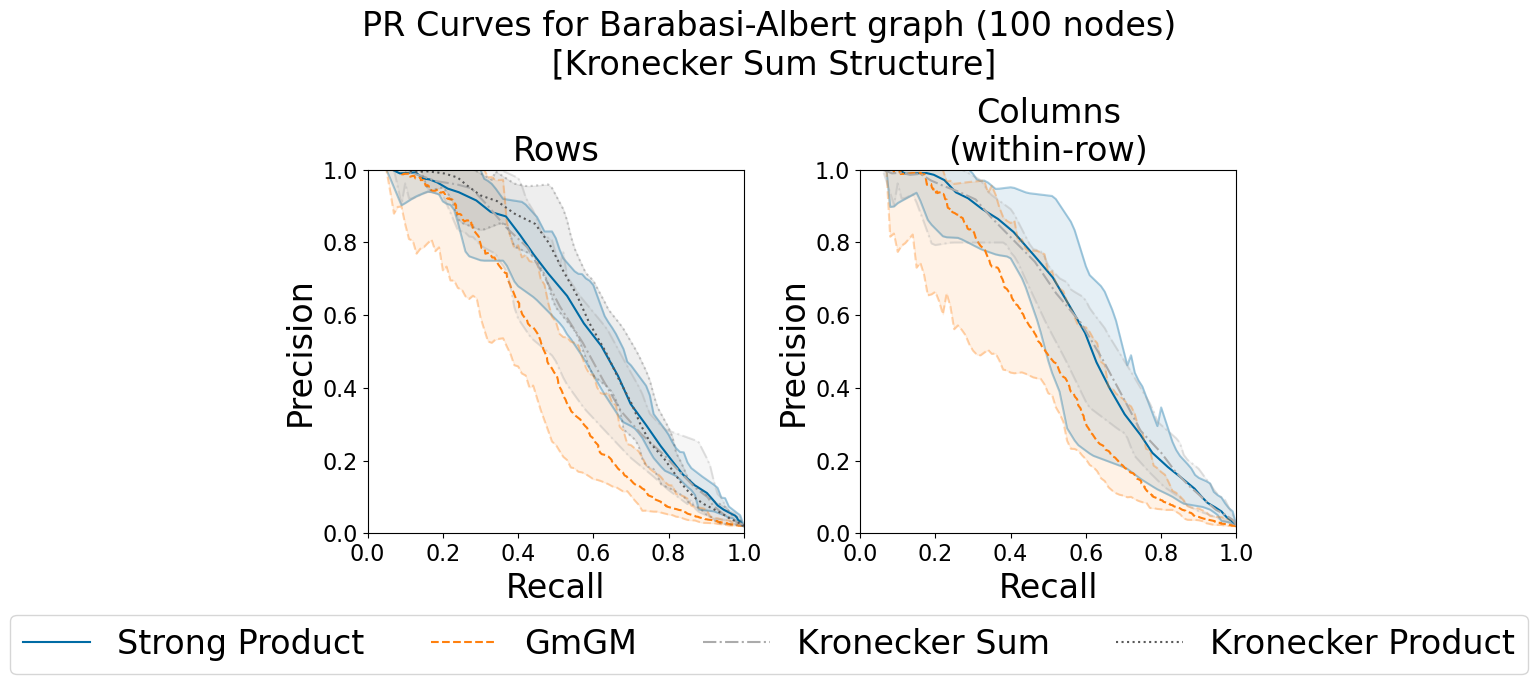

In [15]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Sum Structure",
    num_trials=10,
    model="Kronecker Sum"
)
fig.savefig('./out_figs/synthetic/ks_barabasi.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.049742230322455804
logm result may be inaccurate, approximate err = 0.002070473650896404
logm result may be inaccurate, approximate err = 3.942131213395516e-05
logm result may be inaccurate, approximate err = 3.933262845453269e-05
logm result may be inaccurate, approximate err = 3.951982649515657e-05
logm result may be inaccurate, approximate err = 3.952184735010688e-05
logm result may be inaccurate, approximate err = 3.9522352416892176e-05
logm result may be inaccurate, approximate err = 3.9522478667438686e-05
logm result may be inaccurate, approximate err = 3.277648087573817e-05
logm result may be inaccurate, approximate err = 3.936889009674066e-05
logm result may be inaccurate, approximate err = 3.9522489521335575e-05
logm result may be inaccurate, approximate err = 4.154677723456342e-13
logm result may be inaccurate, approximate err = 2.07591386608767e-05
logm result may be inaccurate, approxim

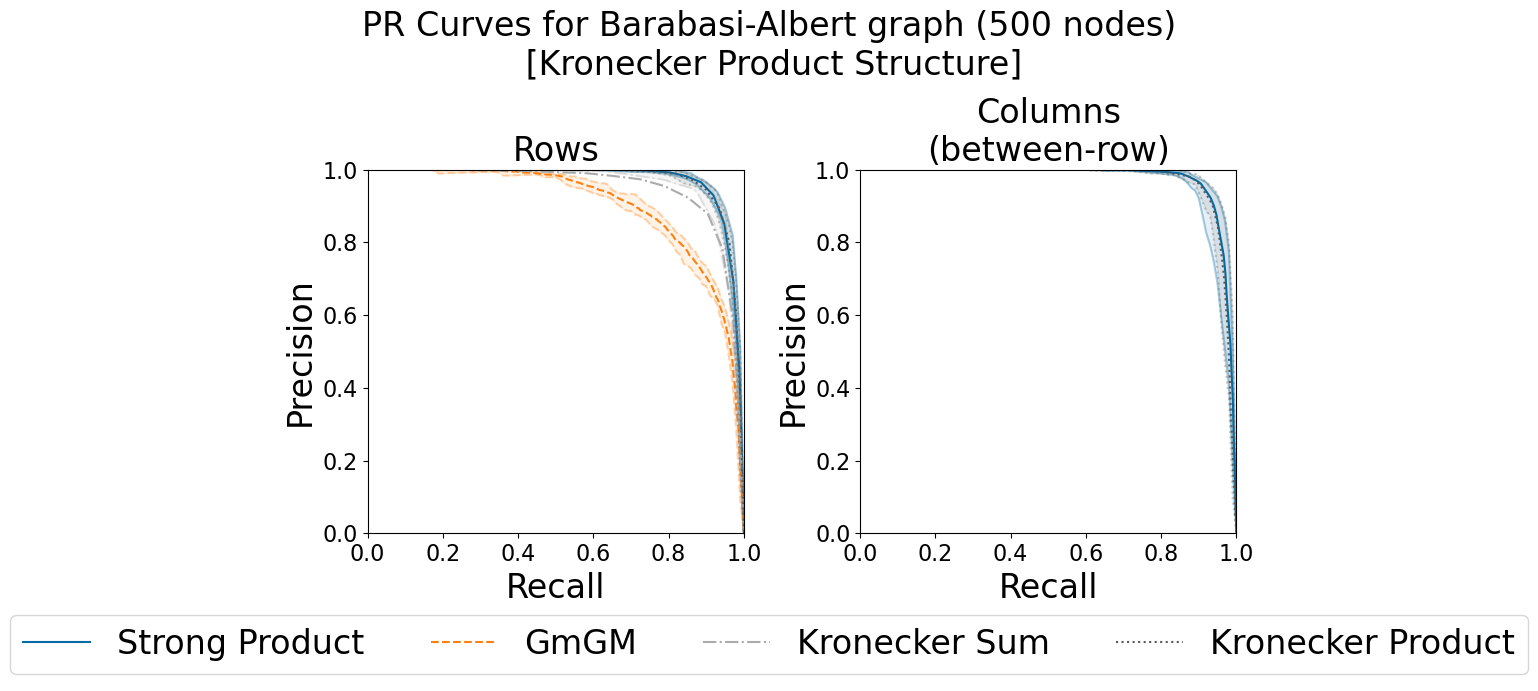

In [16]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Product Structure",
    num_trials=10,
    model="Kronecker Product"
)
fig.savefig('./out_figs/synthetic/kp_barabasi_500.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


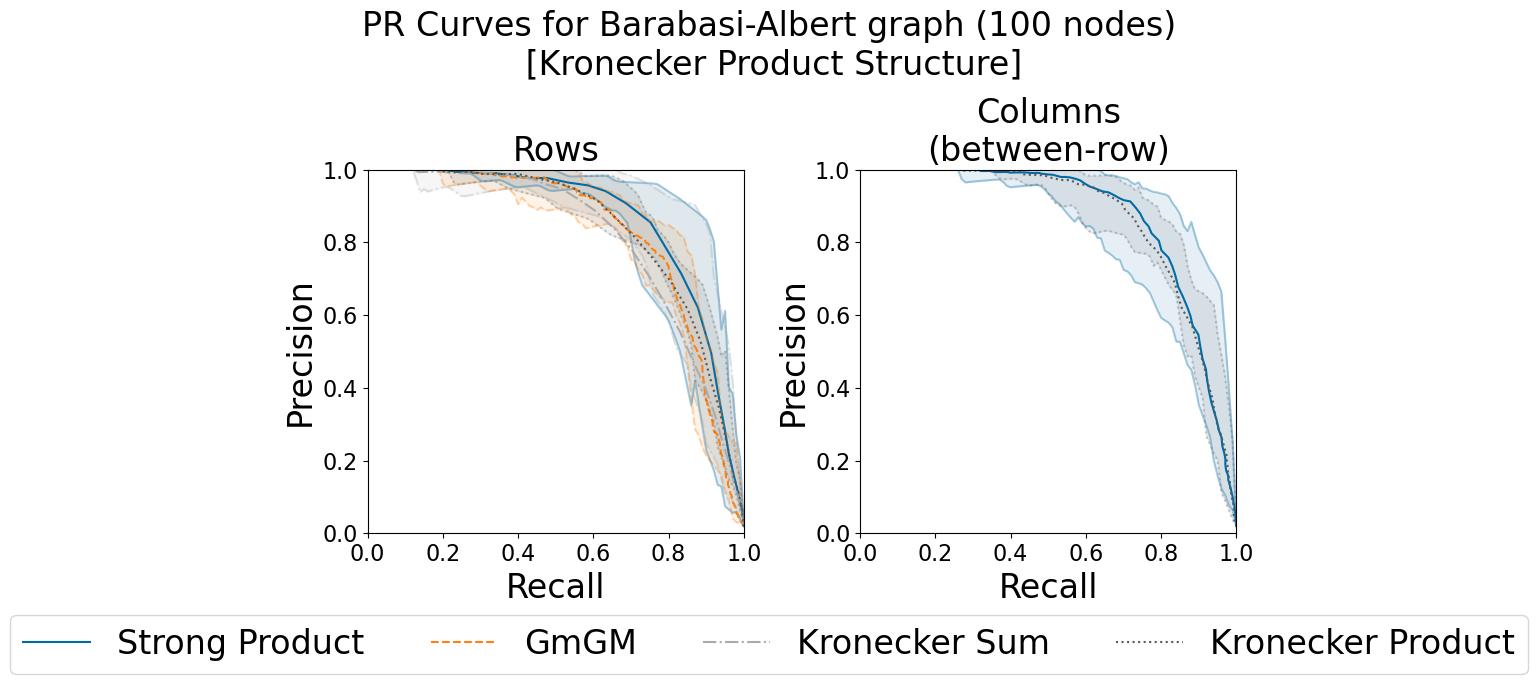

In [17]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Product Structure",
    num_trials=10,
    model="Kronecker Product"
)
fig.savefig('./out_figs/synthetic/kp_barabasi.pdf', bbox_inches="tight")

# AUPR cb-ratio

In [66]:
def aupr(
    num_nodes: int,
    graphs: list[ig.Graph],
    cb_cw_ratio: float = 1.0,
    row_coefficient: float = 1.0,
    rho: float = 0.1,
    tol: float = 1e-3,
    max_iter: int = 100,
    beta: float = 0.5
) -> tuple[float]:

    # Create a random graph
    def random_graph(graph):
        ground_truth = np.array(graph.get_adjacency().data)
        gt_sums = 1 / np.sqrt(ground_truth.sum(axis=0))
        ground_truth = gt_sums.reshape(1, -1) * ground_truth * gt_sums.reshape(-1, 1)

        # Add diagonal so that it forms a PSD matrix!
        ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
        return ground_truth
    
    ground_truth_r = row_coefficient * random_graph(graphs[0])
    ground_truth_cw = random_graph(graphs[1]) / np.sqrt(cb_cw_ratio)
    ground_truth_cb = np.sqrt(cb_cw_ratio) * random_graph(graphs[2])

    # ps_r = []
    # rs_r = []
    # ps_cw = []
    # rs_cw = []
    # ps_cb = []
    # rs_cb = []

    output = fast_strong_product(
        ground_truth_r,
        ground_truth_cw,
        ground_truth_cb
    )

    result = None
    class result_container:
        # Jerry-rigged class to hold the result
        def __init__(self, precmats):
            self.precision_matrices = precmats
            self.precision_matrices["rows"] = precmats["rows"]
            self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
            self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
    result = strong_product_model(
        data_matrix=output,
        rho_rows=rho,
        rho_cols_within_rows=rho,
        rho_cols_between_rows=rho,
        verbose=False,
        tol=tol,
        beta=beta,
        max_iter=max_iter
    )
    result = result_container(result)

    ys_r, xs_r = pr_curve(ground_truth_r, result.precision_matrices["rows"])
    ys_cw, xs_cw = pr_curve(ground_truth_cw, result.precision_matrices["cols_within_rows"])
    ys_cb, xs_cb = pr_curve(ground_truth_cb, result.precision_matrices["cols_between_rows"])
    
    # if ys_r is not None and xs_r is not None:
    #     ps_r.append(ys_r)
    #     rs_r.append(xs_r)
    # if ys_cw is not None and xs_cw is not None:
    #     ps_cw.append(ys_cw)
    #     rs_cw.append(xs_cw)
    # if ys_cb is not None and xs_cb is not None:
    #     ps_cb.append(ys_cb)
    #     rs_cb.append(xs_cb)
    if xs_r is None or ys_r is None:
        auc_1 = 0
    else:
        auc_1 = auc(xs_r, ys_r)
    if xs_cw is None or ys_cw is None:
        auc_2 = 0
    else:
        auc_2 = auc(xs_cw, ys_cw)
    if xs_cb is None or ys_cb is None:
        auc_3 = 0
    else:
        auc_3 = auc(xs_cb, ys_cb)
    

    return auc_1, auc_2, auc_3

Iteration 1, Ratio 0.01
Iteration 3, Ratio 5.005
Iteration 5, Ratio 10.0


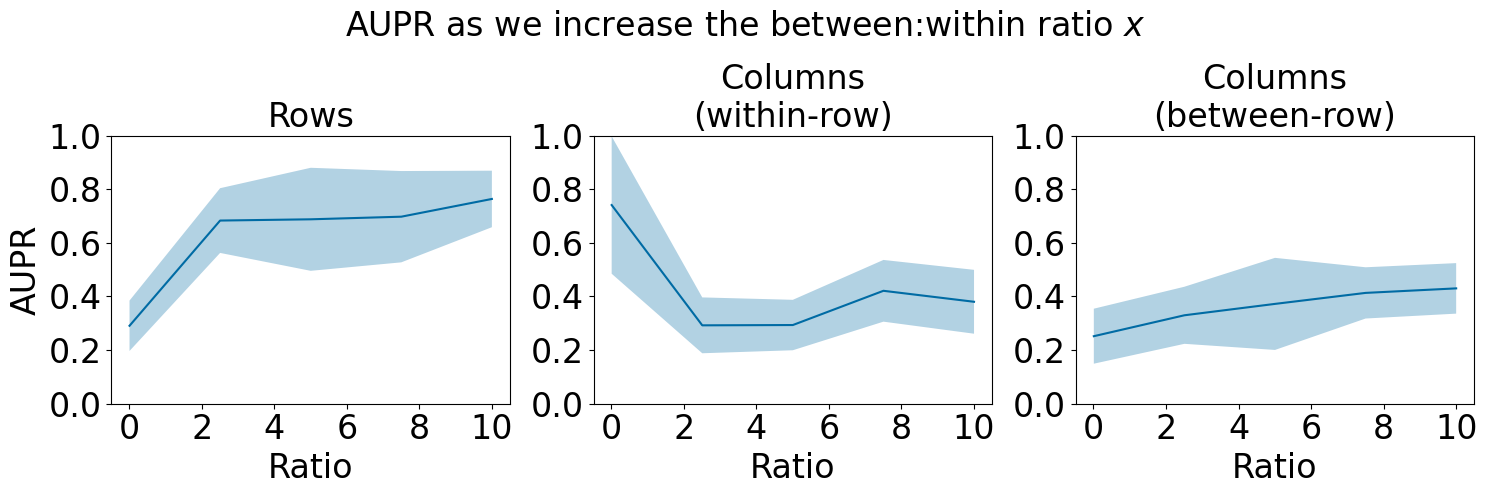

In [19]:
# This is a quick tester cell to ensure the figure gets generated properly.

random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
num_trials = 10
cb_ratios = np.linspace(0.01, 10, 5)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, cb_ratio in enumerate(cb_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {cb_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            cb_cw_ratio=cb_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(cb_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(cb_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(cb_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Ratio")
ax2.set_xlabel("Ratio")
ax3.set_xlabel("Ratio")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    cb_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    cb_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    cb_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

fig.suptitle("AUPR as we increase the between:within ratio $x$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/TEST2.pdf', bbox_inches="tight")

Iteration 1, Ratio 0.01
Iteration 3, Ratio 0.8425
Iteration 5, Ratio 1.675
Iteration 7, Ratio 2.5075
Iteration 9, Ratio 3.34
Iteration 11, Ratio 4.172499999999999
Iteration 13, Ratio 5.005
Iteration 15, Ratio 5.8375
Iteration 17, Ratio 6.67
Iteration 19, Ratio 7.5024999999999995
Iteration 21, Ratio 8.334999999999999
Iteration 23, Ratio 9.1675
Iteration 25, Ratio 10.0


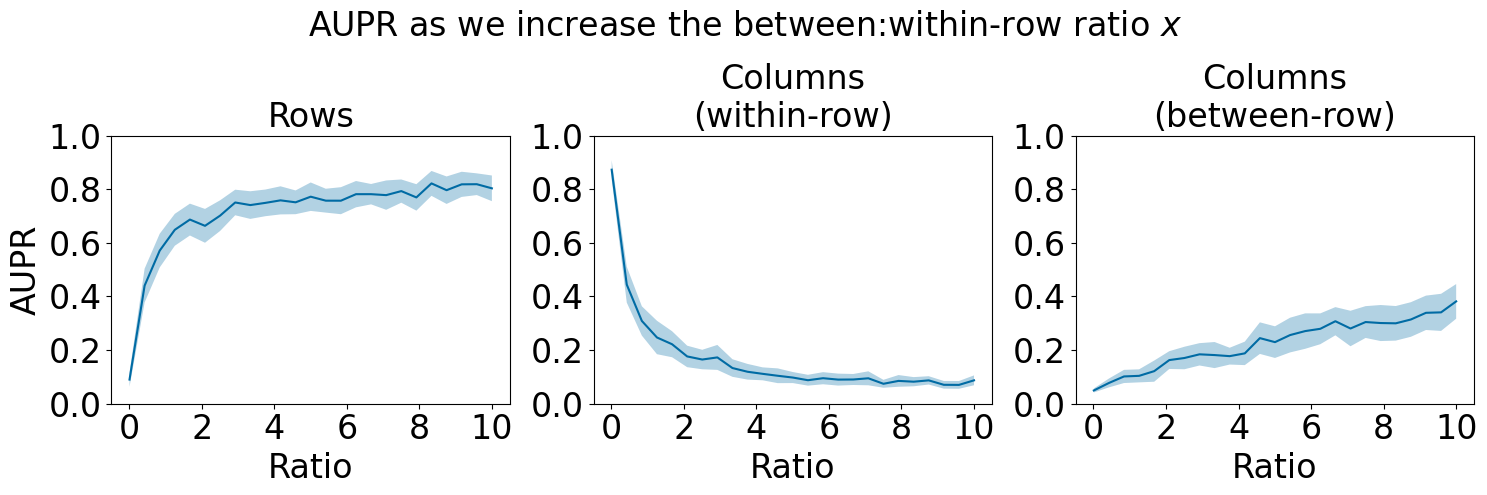

In [20]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 50
num_trials = 50
cb_ratios = np.linspace(0.01, 10, 25)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, cb_ratio in enumerate(cb_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {cb_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            cb_cw_ratio=cb_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(cb_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(cb_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(cb_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Ratio")
ax2.set_xlabel("Ratio")
ax3.set_xlabel("Ratio")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    cb_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    cb_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    cb_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

fig.suptitle("AUPR as we increase the between:within-row ratio $x$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/bw-ratio-change.pdf', bbox_inches="tight")

Iteration 1, Ratio 0.01
Iteration 3, Ratio 0.8425
Iteration 5, Ratio 1.675
Iteration 7, Ratio 2.5075
Iteration 9, Ratio 3.34
Iteration 11, Ratio 4.172499999999999
Iteration 13, Ratio 5.005
Iteration 15, Ratio 5.8375
Iteration 17, Ratio 6.67
Iteration 19, Ratio 7.5024999999999995
Iteration 21, Ratio 8.334999999999999
Iteration 23, Ratio 9.1675
Iteration 25, Ratio 10.0


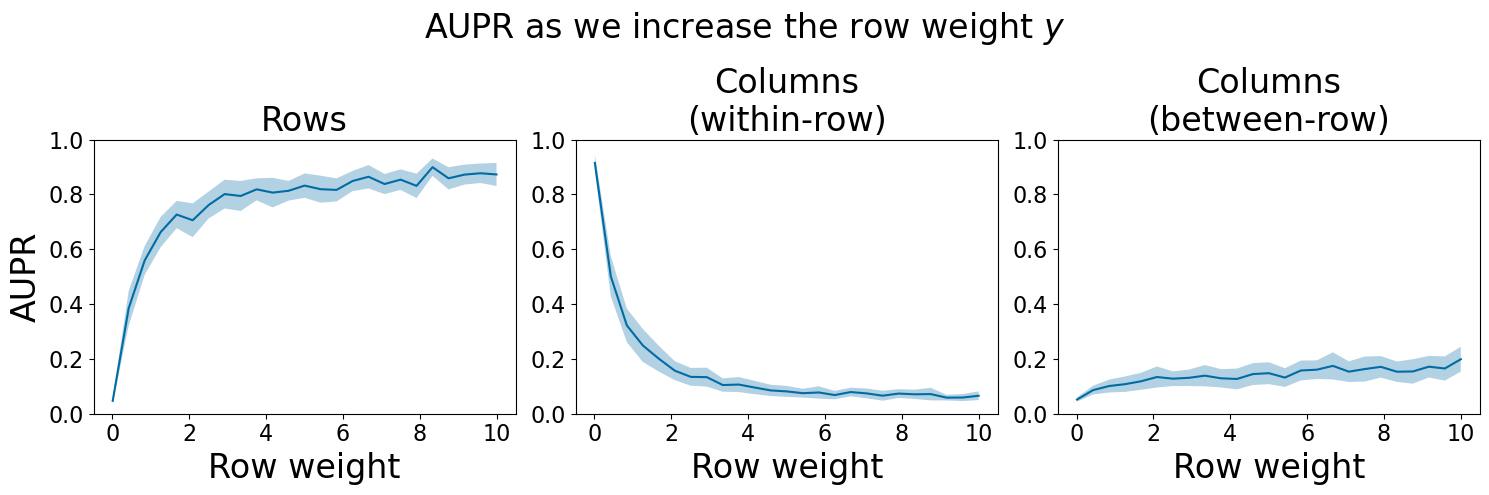

In [21]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 50
num_trials = 50
row_ratios = np.linspace(0.01, 10, 25)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, row_ratio in enumerate(row_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {row_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            row_coefficient=row_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(row_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(row_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(row_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Row weight")
ax2.set_xlabel("Row weight")
ax3.set_xlabel("Row weight")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    row_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    row_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    row_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(24)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(16)

fig.suptitle("AUPR as we increase the row weight $y$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/row-precision-increase.pdf', bbox_inches="tight")

## Warning: the next two code cells take a long time to run

Iteration 1, Ratio 0.01
	Trial 1 of 25
logm result may be inaccurate, approximate err = 0.037237777015350706
	Trial 2 of 25
logm result may be inaccurate, approximate err = 0.03228151633308153
logm result may be inaccurate, approximate err = 0.036825518989681706
logm result may be inaccurate, approximate err = 1.9607973844091992e-12
logm result may be inaccurate, approximate err = 1.9744175645009933e-12
logm result may be inaccurate, approximate err = 6.788921295237396e-05
logm result may be inaccurate, approximate err = 1.2909887406708805e-05
logm result may be inaccurate, approximate err = 1.9779434124643483e-12
logm result may be inaccurate, approximate err = 1.9815351697980838e-12
logm result may be inaccurate, approximate err = 6.63837084599296e-05
logm result may be inaccurate, approximate err = 1.9720998581428414e-12
logm result may be inaccurate, approximate err = 1.494053769039031e-05
logm result may be inaccurate, approximate err = 3.624630773217825e-05
logm result may be ina

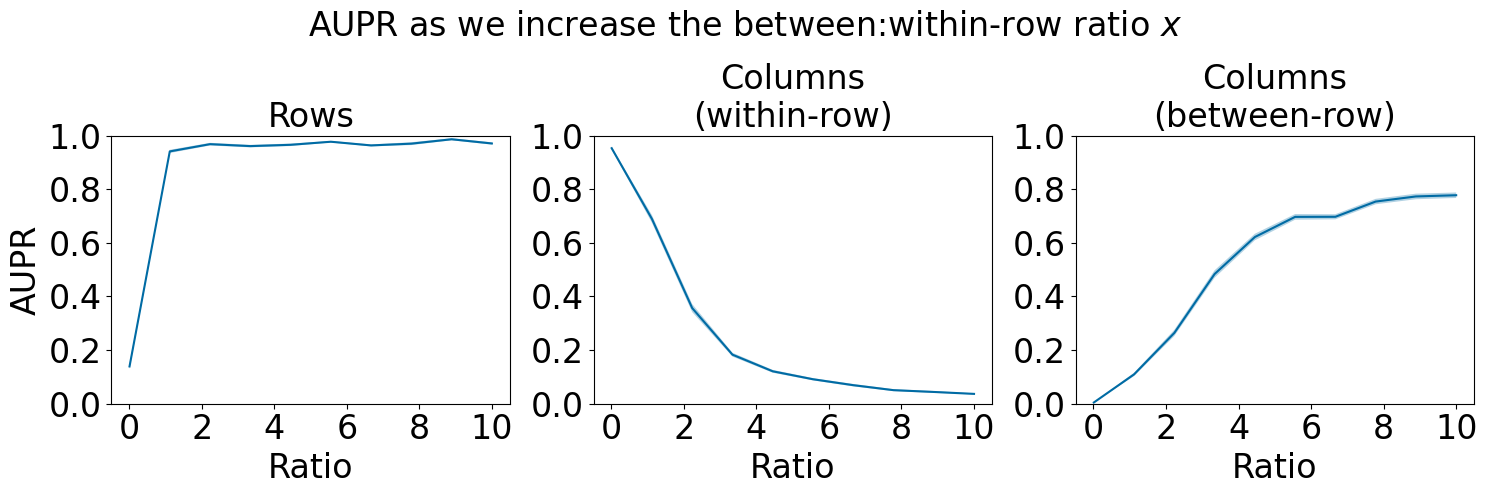

In [24]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 500
num_trials = 25
cb_ratios = np.linspace(0.01, 10, 10)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, cb_ratio in enumerate(cb_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    print(f"Iteration {i+1}, Ratio {cb_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        print(f"\tTrial {trial+1} of {num_trials}")
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            cb_cw_ratio=cb_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(cb_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(cb_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(cb_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Ratio")
ax2.set_xlabel("Ratio")
ax3.set_xlabel("Ratio")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    cb_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    cb_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    cb_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

fig.suptitle("AUPR as we increase the between:within-row ratio $x$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/bw-ratio-change_500.pdf', bbox_inches="tight")

Iteration 1, Ratio 0.01
	Trial 1 of 25
logm result may be inaccurate, approximate err = 0.02219591941161202
logm result may be inaccurate, approximate err = 4.0363383712949245e-05
logm result may be inaccurate, approximate err = 4.091003866088528e-06
logm result may be inaccurate, approximate err = 4.036365050413277e-05
logm result may be inaccurate, approximate err = 3.9331807967171545e-13
logm result may be inaccurate, approximate err = 3.906406850640965e-13
logm result may be inaccurate, approximate err = 4.0363728346857496e-05
logm result may be inaccurate, approximate err = 3.9059322531854754e-13
logm result may be inaccurate, approximate err = 3.948691034586354e-13
logm result may be inaccurate, approximate err = 4.036373738557989e-05
logm result may be inaccurate, approximate err = 7.826090486199274e-06
logm result may be inaccurate, approximate err = 4.036373790010965e-05
	Trial 2 of 25
logm result may be inaccurate, approximate err = 0.022579717365687133
logm result may be ina

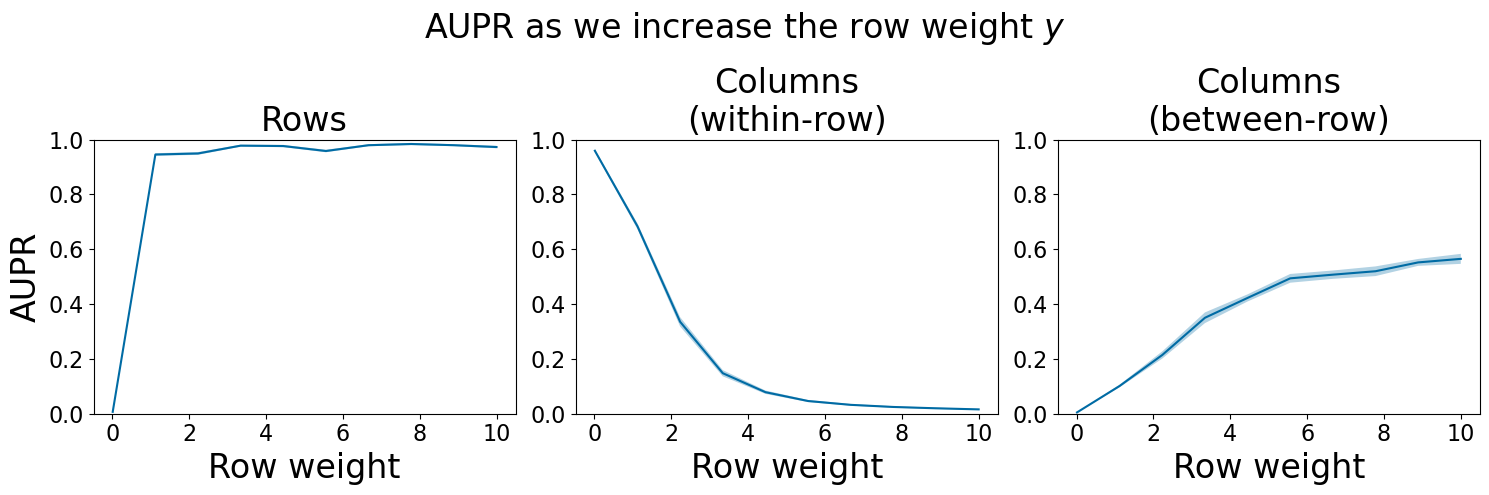

In [25]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 500
num_trials = 25
row_ratios = np.linspace(0.01, 10, 10)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, row_ratio in enumerate(row_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    print(f"Iteration {i+1}, Ratio {row_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        print(f"\tTrial {trial+1} of {num_trials}")
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            row_coefficient=row_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(row_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(row_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(row_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Row weight")
ax2.set_xlabel("Row weight")
ax3.set_xlabel("Row weight")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    row_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    row_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    row_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(24)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(16)

fig.suptitle("AUPR as we increase the row weight $y$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/row-precision-increase_500.pdf', bbox_inches="tight")

## AUPR for Rho

Iteration 1, Rho 1e-05
Iteration 3, Rho 0.000379269019073225
Iteration 5, Rho 0.01438449888287663
Iteration 7, Rho 0.5455594781168515
Iteration 9, Rho 20.6913808111479
Iteration 11, Rho 784.7599703514622
Iteration 13, Rho 29763.51441631313
Iteration 15, Rho 1128837.8916846884
Iteration 17, Rho 42813323.98719396
Iteration 19, Rho 1623776739.1887243


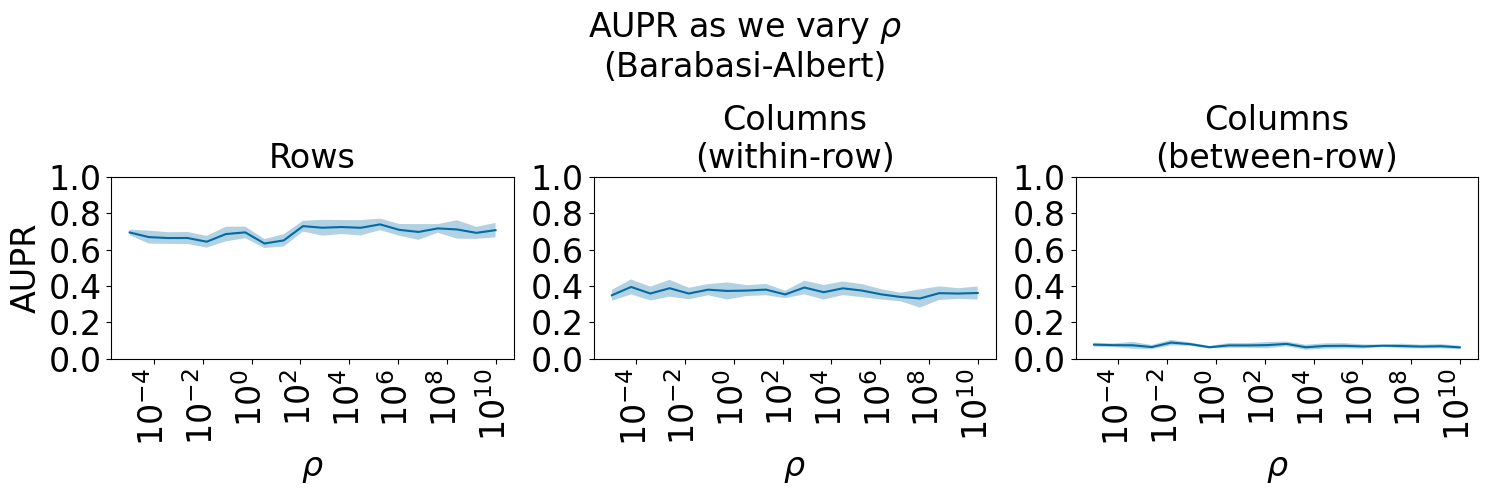

In [90]:
# This is a quick tester cell to ensure the figure gets generated properly.

random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 100
num_trials = 10
rhos = 10**np.linspace(-5, 10, 20)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, rho in enumerate(rhos):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Rho {rho}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            rho=rho,
            beta=0,
            tol=1e-3,
            max_iter=100
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(rhos, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(rhos, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(rhos, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel(r"$\rho$")
ax2.set_xlabel(r"$\rho$")
ax3.set_xlabel(r"$\rho$")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    rhos,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    rhos,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    rhos,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Set log scale
ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")

# Rotate x labels
for ax in [ax1, ax2, ax3]:
    for item in ax.get_xticklabels():
        item.set_rotation(90)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

fig.suptitle(r"AUPR as we vary $\rho$" + "\n(Barabasi-Albert)", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/rho-varies-barabasi.pdf', bbox_inches="tight")

# Convergence

In [26]:
random.seed(SEED)
np.random.seed(SEED)
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)
data = fast_strong_product(
    random_graph(graph1),
    random_graph(graph2),
    random_graph(graph3)
)

results = strong_product_model(
    data_matrix=data,
    rho_rows=0.1,
    rho_cols_within_rows=0.1,
    rho_cols_between_rows=0.1,
    verbose=True,
    tol=1e-100,
    return_errors=True
)

Iteration 1: 33125.585429273255
Iteration 2: 19828.681962960283
logm result may be inaccurate, approximate err = 0.02320727913613361
Iteration 3: 14158.740910530963
logm result may be inaccurate, approximate err = 0.024085875167258426
Iteration 4: 11511.94080698461
logm result may be inaccurate, approximate err = 1.1133924524469685e-05
Iteration 5: 10230.386232567776
logm result may be inaccurate, approximate err = 4.0346869398722945e-05
Iteration 6: 9599.503328579187
logm result may be inaccurate, approximate err = 3.012666618970508e-05
Iteration 7: 9521.185037864896
logm result may be inaccurate, approximate err = 4.551834190858594e-05
Iteration 8: 9482.063117659825
Iteration 9: 9477.17496763065
Iteration 10: 9476.56398151035
Iteration 11: 9476.258490716747
Iteration 12: 9476.10574588651
Iteration 13: 9476.08665281476
logm result may be inaccurate, approximate err = 3.300810243867944e-05
Iteration 14: 9476.081879547972
Iteration 15: 9476.079492914141
Iteration 16: 9476.079194585327
I

[73771.11906711 33125.58542927 19828.68196296 14158.74091053
 11511.94080698 10230.38623257  9599.50332858  9521.18503786
  9482.06311766  9477.17496763  9476.56398151  9476.25849072
  9476.10574589  9476.08665281  9476.08187955  9476.07949291
  9476.07919459  9476.07912     9476.07908271  9476.07906407
  9476.07905474  9476.07905008  9476.0790495   9476.07904921
  9476.07904906  9476.07904899  9476.07904897  9476.07904897
  9476.07904896  9476.07904896  9476.07904896  9476.07904896]


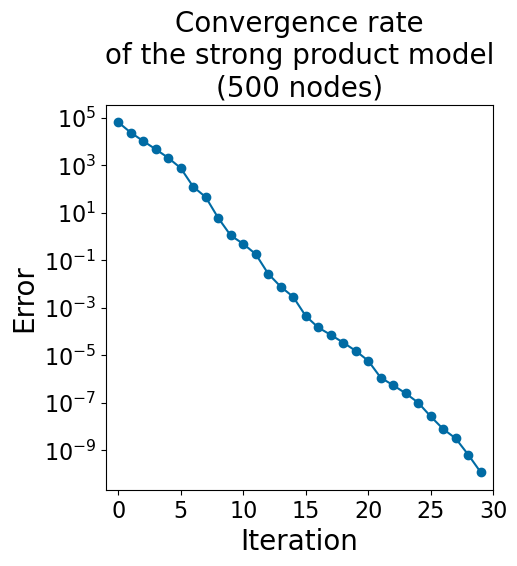

In [27]:
errors = np.array(results["errors"])
print(errors)
errors -= errors[-1]
errors = errors[:-2] # Second-to-last error is same b/c of convergence criterion
errors = np.abs(errors)

# Show convergence over time
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
ax.plot(errors, linestyle='-', marker='o')
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")
ax.set_yscale("log")
ax.set_xlim(-1, len(errors))
ax.set_title(f"Convergence rate\nof the strong product model\n({num_nodes} nodes)")

# Increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(20)

for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(16)

fig.savefig('./out_figs/synthetic/convergence-rate.pdf', bbox_inches="tight")